# STEP 1 Install Darknet

In [ ]:
%%capture
!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet
import re
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make
!chmod +x ./darknet

In [ ]:
#utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  

# Clone a helper repo

It makes training the medical mask detecting model easy. In order to train on your own data, this repo can be used as a blueprint. Changes to some files need to be made according to own data, but it is nothing complicated.

In [ ]:
repo_url = 'https://github.com/GotG/yolotinyv3_medmask_demo'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url}
%cd {repo_dir_path}

/content
Cloning into 'yolotinyv3_medmask_demo'...
remote: Enumerating objects: 1733, done.
remote: Total 1733 (delta 0), reused 0 (delta 0), pack-reused 1733
Receiving objects: 100% (1733/1733), 208.88 MiB | 23.33 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Updating files: 100% (1537/1537), done.
/content/yolotinyv3_medmask_demo


# Change the labels in obj.names to our current labels

In [ ]:
labels_path = '/content/yolotinyv3_medmask_demo/obj.names'
#make a list of your labels
labels = ['fido','Scotia','Virgin']
with open(labels_path, 'w') as f:

    f.write('\n'.join(labels))

#check that the labels file is correct
!cat /content/yolotinyv3_medmask_demo/obj.names

fido
Scotia
Virgin

# Change the number of classes in obj.data.
The paths are relative so no change there as long as the folder/file structure/names are not changed.

In [ ]:
import re
objdata = '/content/yolotinyv3_medmask_demo/obj.data'
with open(objdata) as f:
    s = f.read()

#the number of classes is equal to the number of labels
num_classes = len(labels)   
s = re.sub('classes= \d*','classes = ' + str(num_classes),s)
with open(objdata, 'w') as f:
  f.write(s)
!cat /content/yolotinyv3_medmask_demo/obj.data

classes = 3
train  = /content/yolotinyv3_medmask_demo/train.txt
valid  = /content/yolotinyv3_medmask_demo/valid.txt
names = /content/yolotinyv3_medmask_demo/obj.names
backup = backup/

## Now we need to create a train.txt, valid.txt and test.txt file for our images from `obj` folder.
We will use a script that splits the images based on a specified percentage 
and writes them in train.txt, valid.txt and test.txt files.

In [ ]:
%cd ../yolotinyv3_medmask_demo/

#in this case we use 85 percent of the images for training
#10 percent for validation, 5 for testing.
#as the dataset is small, one can use 90 percent for training and split the rest
#for validation/testing as desired.
#double clicking on the train or test text files will open the file in a new
#tab in colab and display the content.
#!python3 folder2textYolo.py 85 10 /content/yolotinyv3_medmask_demo/obj

/content/yolotinyv3_medmask_demo


In [ ]:
# code to delete
%cd /content/yolotinyv3_medmask_demo/obj
%rm *

/content/yolotinyv3_medmask_demo/obj


In [ ]:
%cd /content/darknet
%rm *

##Last thing we need to change is the yolov4-tiny_obj.cfg file.

There are several parameters of importance here. They control various aspects of the training process. Let's print the first few lines and have a look

In [ ]:
!head -n 24 /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg


[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=1
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1



In [ ]:
# set the number of max_batches - min 2000 per class:
max_batch=2500
# calculate the 2 steps values:
step1 = 0.4 * max_batch
step2 = 0.7 * max_batch
step3 = 0.9 * max_batch
#subdivisions define the minibatch size: minibatch = batch/subdivisions
#we set subdivisions to 4. if using larger resolutions, may have to increase
#the this number to 8 16 or even 32. default resolution is 416x416
subdivisions = 4


# we also need to adjust the number of classes and a parameter called filter size 
# that are both is inside the model structure

# num_classes = len(labels)
num_filters = (num_classes + 5) * 3

cfg_file = '/content/yolotinyv3_medmask_demo/yolov4-tiny.cfg'

with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('subdivisions=\d*','subdivisions='+str(subdivisions),s)
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2)+','+"{:.0f}".format(step3),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)


In [ ]:
!head -n 24 /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg

[net]
# Testing
#batch=1
#subdivisions=4
# Training
batch=64
subdivisions=4
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = 2500
policy=steps
steps=1000,1750,2250
scales=.1,.1,.1



In [ ]:
!tail -n 64 /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg 


mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=3
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
resize=1.5
nms_kind=greedynms
beta_nms=0.6

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 23

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=24
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=3
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
resize=1.5
nms_kind=greedynms
beta_nms=0.6


## Start the model training

1.   List item
2.   List item


For training details check here: 

https://github.com/AlexeyAB/darknet#how-to-train-tiny-yolo-to-detect-your-custom-objects

In [ ]:
%cd

/root


In [ ]:
%cd /content/darknet

/content/darknet


In [ ]:
!./darknet detector train /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg /content/yolotinyv3_medmask_demo/yolov4-tiny.conv.29 -dont_show -ext_output -map

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.859698), count: 1, class_loss = 0.000105, iou_loss = 0.047213, total_loss = 0.047318 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.820934), count: 11, class_loss = 0.037447, iou_loss = 4.096266, total_loss = 4.133712 
 total_bbox = 116087, rewritten_bbox = 0.000000 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.754801), count: 1, class_loss = 0.039455, iou_loss = 0.035418, total_loss = 0.074873 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.836715), count: 10, class_loss = 0.061080, iou_loss = 3.420730, total_loss = 3.481810 
 total_bbox = 116098, rewritten_bbox = 0.000000 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.693233), count: 1, class_loss = 0.019970, iou_loss = 0.022232, total_loss = 0.042202 
v3 (i

## Check the model performance
The metrics run on the validation images so they may not be fully representative, only indicative

In [ ]:
!./darknet detector map /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg "/content/darknet/backup/yolov4-tiny_best.weights" -points 0

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 


#Run detection on an image. I choose one of the test images from test.txt

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 4, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	     

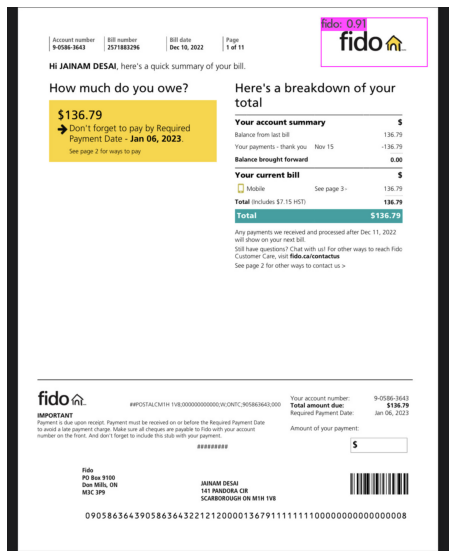

In [ ]:
!./darknet detector test /content/yolotinyv3_medmask_demo/obj.data  /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg  "/content/darknet/backup/yolov4-tiny_best.weights" /content/yolotinyv3_medmask_demo/obj/fido_1.jpg -ext_output
imShow('predictions.jpg')

#Copy best weights to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/darknet/backup/yolov4-tiny_best.weights  '/content/drive/My Drive/'


In [ ]:
%cd /content/darknet

/content/darknet


In [ ]:
!./darknet detector test /content/obj.data  /content/yolov4-tiny.cfg  "/content/fido_2 copy 8.jpg" -ext_output
imShow('predictions.jpg')

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 4, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	     

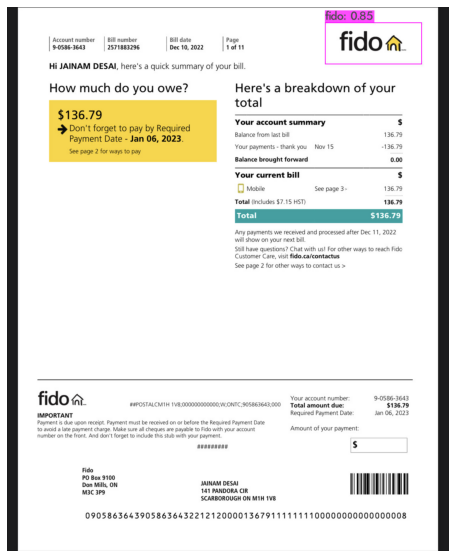

In [ ]:
!./darknet detector test /content/yolotinyv3_medmask_demo/obj.data  /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg  "/content/darknet/backup/yolov4-tiny_best.weights" "/content/yolotinyv3_medmask_demo/obj/test/fido_1.jpg" -ext_output
imShow('predictions.jpg')

#Testing

In [ ]:
%cd /content/darknet

/content/darknet


##For Fido

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 4, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	     

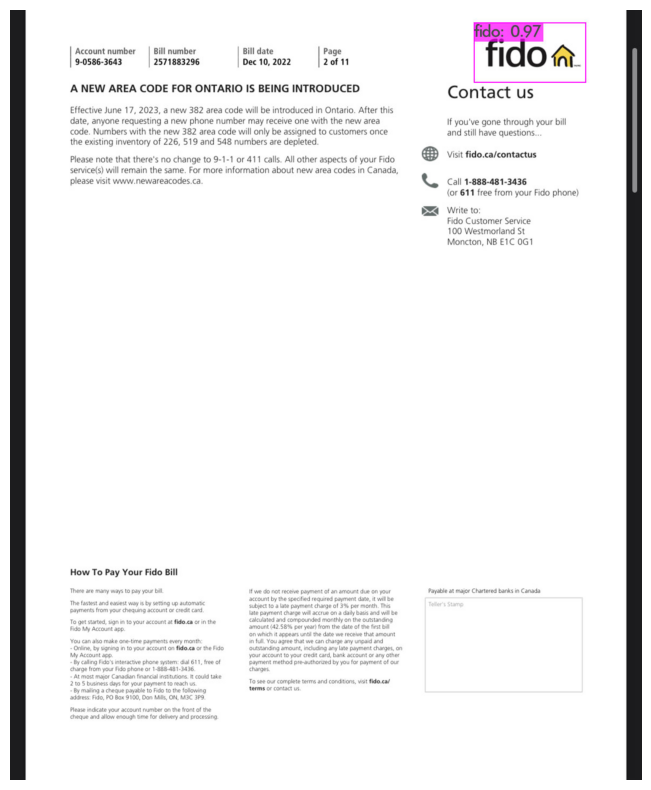

In [ ]:
!./darknet detector test /content/obj.data  /content/yolov4-tiny.cfg  "/content/yolov4-tiny_best.weights" "/content/fido_2 copy 8.jpg" -ext_output
imShow('predictions.jpg')

## For Virgin

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 4, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	     

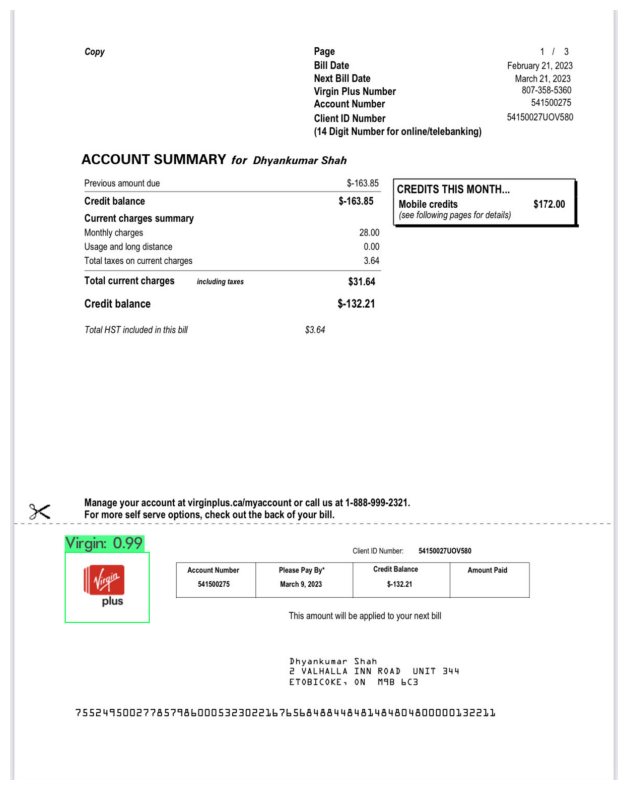

In [ ]:
!./darknet detector test /content/obj.data  /content/yolov4-tiny.cfg  "/content/yolov4-tiny_best.weights" "/content/Virgin copy 12.jpg" -ext_output
imShow('predictions.jpg')

## For Scotia

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 4, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	     

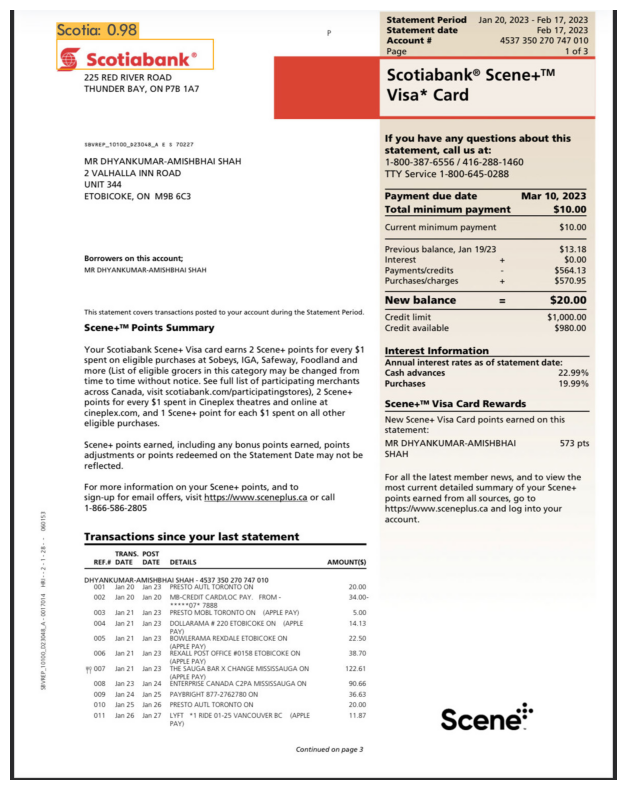

In [ ]:
!./darknet detector test /content/obj.data  /content/yolov4-tiny.cfg  "/content/yolov4-tiny_best.weights" "/content/Scotia_1 copy 14.jpg" -ext_output
imShow('predictions.jpg')